# 2D-CNN pipeline (images ready)

In [17]:
# ====== Imports ======
import os, random
import numpy as np
import pandas as pd
from scipy.stats import iqr
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# ====== Colab drive mount ======
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/CR.zip -d /content/CR

Archive:  /content/CR.zip
   creating: /content/CR/CR_16_auto_scale/
   creating: /content/CR/CR_16_norm/
   creating: /content/CR/CR_65_snake_auto_scale/
   creating: /content/CR/CR_65_snake_norm/
  inflating: /content/CR/CR_16_auto_scale/RESAMP_306.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_768.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_722.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_772.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_441.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_129.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_43.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_618.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_105.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_127.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_610.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_176.png  
  inflating: /content/CR/CR_16_auto_scale/RESAMP_182.png  
  inflating: /content/CR/CR_16_auto_

In [6]:
# ====== Paths ======
IMG_DIR = "/content/CR/CR_65_snake_auto_scale"
CSV_PATH = "/content/train_df_averaged.csv"

TARGETS = ['Moi','NDF',  'Starch']
IMG_SIZE = 65 #------------------------------------------>16

In [7]:
# ====== Hyperparams ======
batch_size = 128
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [8]:
# ====== Load CSV ======
df = pd.read_csv(CSV_PATH)
# df = df.groupby('Sample ID').mean() # If the data is not averaged
# df = df.dropna(subset=TARGETS).reset_index(drop=True)
print("Data shape:", df.shape)

Data shape: (784, 261)


In [9]:
# ====== Scale targets ======
from sklearn.preprocessing import StandardScaler
# y_scaler = MinMaxScaler()
y_scaler = StandardScaler() # => Auto scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

In [10]:
plot_name = "SNAKE"  # Change this based on the plot type

In [11]:
# ====== Dataset class (images already ready) ======

class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))  # grayscale
        img = self.transform(img)  # shape (1,H,W)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) -> (1,H,W), float in [0,1]
])

dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform=transform)
print("Dataset length:", len(dataset))

Dataset length: 784


In [12]:
# ====== CNN model (as in Table 2) ======
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

        self.flattened = 512 * 2 * 2
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)
        x = self.relu(self.conv2(x)); x = self.pool(x)
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
        x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [13]:
# ====== Metrics ======
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        rpiq = float(iqr(yt) / rmse) if rmse > 1e-8 else float("inf")
        results.append({"RMSE": rmse, "R2": r2, "RPIQ": rpiq})
    return results

In [14]:
# ====== Split train/test ======
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)


--- Fold 1/5 ---
Epoch 1/200, Loss: 0.9318
Epoch 2/200, Loss: 0.8855
Epoch 3/200, Loss: 0.9775
Epoch 4/200, Loss: 0.9379
Epoch 5/200, Loss: 0.9379
Epoch 6/200, Loss: 1.0954
Epoch 7/200, Loss: 0.8611
Epoch 8/200, Loss: 1.0568
Epoch 9/200, Loss: 0.8815
Epoch 10/200, Loss: 1.0655
Epoch 11/200, Loss: 0.9347
Epoch 12/200, Loss: 0.9002
Epoch 13/200, Loss: 0.7314
Epoch 14/200, Loss: 0.8570
Epoch 15/200, Loss: 1.0254
Epoch 16/200, Loss: 0.6984
Epoch 17/200, Loss: 1.1092
Epoch 18/200, Loss: 0.9100
Epoch 19/200, Loss: 0.9507
Epoch 20/200, Loss: 0.6929
Epoch 21/200, Loss: 0.7810
Epoch 22/200, Loss: 1.0048
Epoch 23/200, Loss: 0.7911
Epoch 24/200, Loss: 1.1132
Epoch 25/200, Loss: 1.2166
Epoch 26/200, Loss: 0.8856
Epoch 27/200, Loss: 0.9503
Epoch 28/200, Loss: 0.9894
Epoch 29/200, Loss: 0.7820
Epoch 30/200, Loss: 0.8491
Epoch 31/200, Loss: 0.9247
Epoch 32/200, Loss: 0.7957
Epoch 33/200, Loss: 0.6654
Epoch 34/200, Loss: 0.6868
Epoch 35/200, Loss: 0.9452
Epoch 36/200, Loss: 1.1301
Epoch 37/200, Loss:

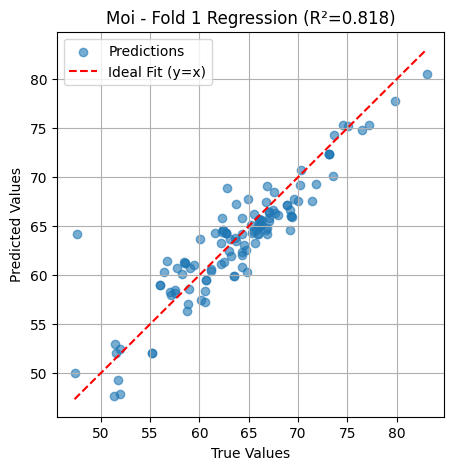

NDF: RMSE=4.120, R2=0.557, RPIQ=2.098


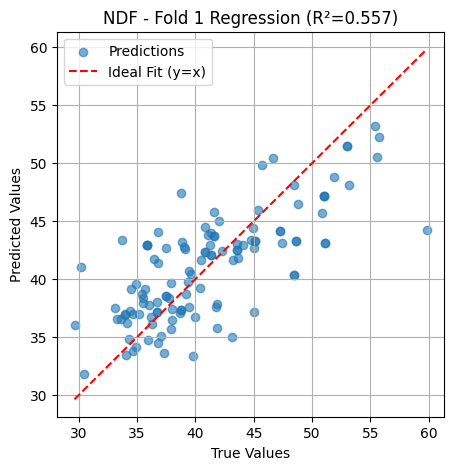

Starch: RMSE=6.314, R2=0.613, RPIQ=1.721


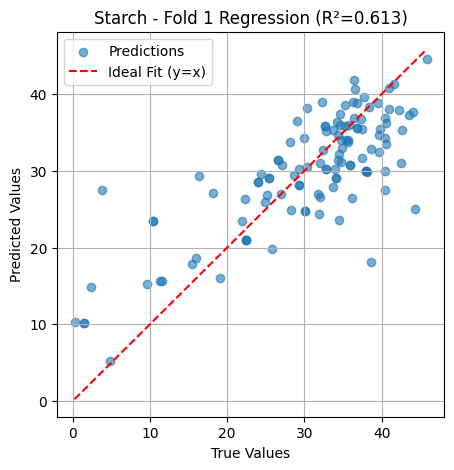


--- Fold 2/5 ---
Epoch 1/200, Loss: 0.8122
Epoch 2/200, Loss: 0.9331
Epoch 3/200, Loss: 1.0503
Epoch 4/200, Loss: 0.7781
Epoch 5/200, Loss: 0.9338
Epoch 6/200, Loss: 0.9342
Epoch 7/200, Loss: 0.9333
Epoch 8/200, Loss: 1.0432
Epoch 9/200, Loss: 0.9522
Epoch 10/200, Loss: 1.0678
Epoch 11/200, Loss: 0.7269
Epoch 12/200, Loss: 0.9431
Epoch 13/200, Loss: 1.0231
Epoch 14/200, Loss: 1.0204
Epoch 15/200, Loss: 1.0374
Epoch 16/200, Loss: 0.7424
Epoch 17/200, Loss: 0.9356
Epoch 18/200, Loss: 0.8117
Epoch 19/200, Loss: 1.0898
Epoch 20/200, Loss: 0.8911
Epoch 21/200, Loss: 1.1687
Epoch 22/200, Loss: 0.8720
Epoch 23/200, Loss: 0.8649
Epoch 24/200, Loss: 0.8420
Epoch 25/200, Loss: 0.8608
Epoch 26/200, Loss: 0.9210
Epoch 27/200, Loss: 0.6921
Epoch 28/200, Loss: 1.2215
Epoch 29/200, Loss: 0.7332
Epoch 30/200, Loss: 0.9417
Epoch 31/200, Loss: 0.9510
Epoch 32/200, Loss: 1.4455
Epoch 33/200, Loss: 0.9579
Epoch 34/200, Loss: 1.3395
Epoch 35/200, Loss: 1.1003
Epoch 36/200, Loss: 1.0964
Epoch 37/200, Loss:

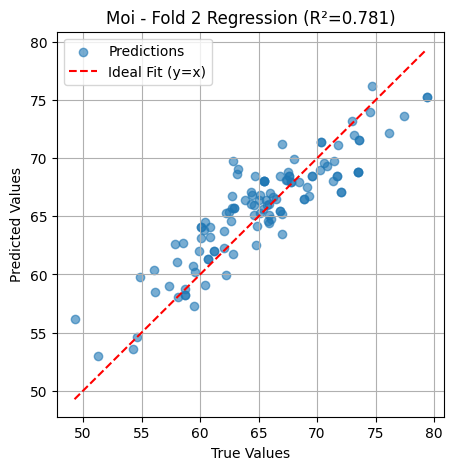

NDF: RMSE=4.600, R2=0.403, RPIQ=1.740


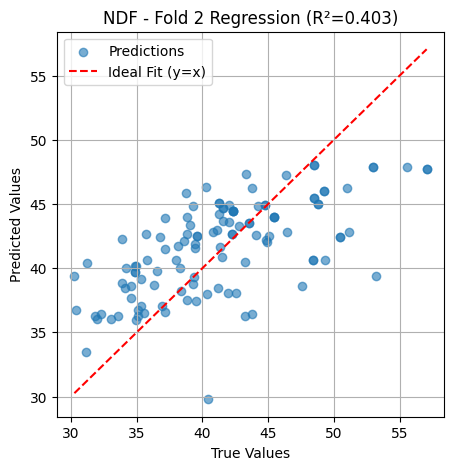

Starch: RMSE=7.291, R2=0.437, RPIQ=1.446


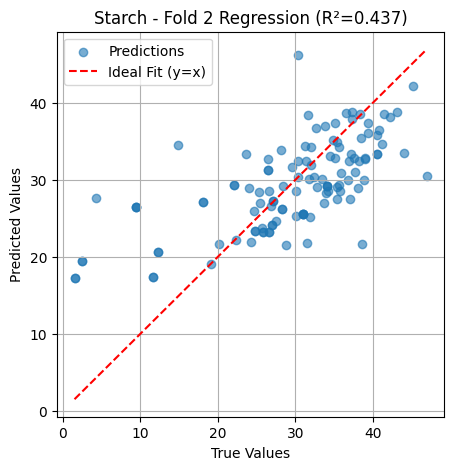


--- Fold 3/5 ---
Epoch 1/200, Loss: 0.9194
Epoch 2/200, Loss: 0.8819
Epoch 3/200, Loss: 0.9105
Epoch 4/200, Loss: 0.9069
Epoch 5/200, Loss: 0.9442
Epoch 6/200, Loss: 0.8282
Epoch 7/200, Loss: 0.9315
Epoch 8/200, Loss: 0.9680
Epoch 9/200, Loss: 0.8118
Epoch 10/200, Loss: 0.8838
Epoch 11/200, Loss: 1.0624
Epoch 12/200, Loss: 0.7500
Epoch 13/200, Loss: 0.8980
Epoch 14/200, Loss: 1.2045
Epoch 15/200, Loss: 0.9820
Epoch 16/200, Loss: 0.8084
Epoch 17/200, Loss: 0.6376
Epoch 18/200, Loss: 0.9472
Epoch 19/200, Loss: 0.9512
Epoch 20/200, Loss: 0.9587
Epoch 21/200, Loss: 1.0840
Epoch 22/200, Loss: 1.2828
Epoch 23/200, Loss: 0.7227
Epoch 24/200, Loss: 0.7986
Epoch 25/200, Loss: 0.8624
Epoch 26/200, Loss: 0.7088
Epoch 27/200, Loss: 1.3217
Epoch 28/200, Loss: 0.8899
Epoch 29/200, Loss: 0.6680
Epoch 30/200, Loss: 1.0701
Epoch 31/200, Loss: 1.0177
Epoch 32/200, Loss: 0.8764
Epoch 33/200, Loss: 1.1123
Epoch 34/200, Loss: 0.7576
Epoch 35/200, Loss: 0.5595
Epoch 36/200, Loss: 1.1075
Epoch 37/200, Loss:

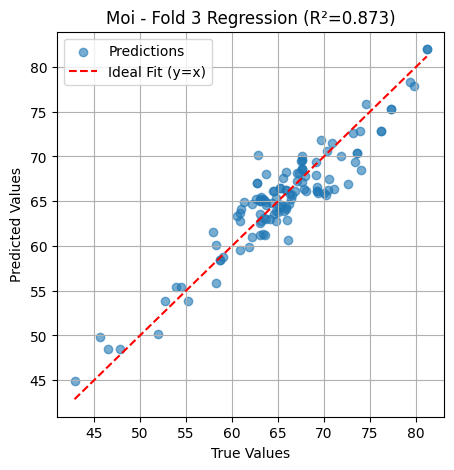

NDF: RMSE=3.962, R2=0.479, RPIQ=1.732


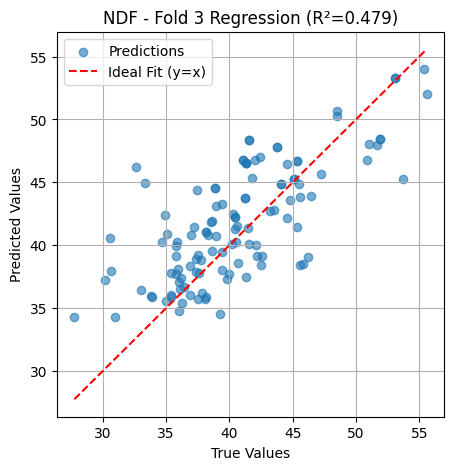

Starch: RMSE=6.043, R2=0.604, RPIQ=1.454


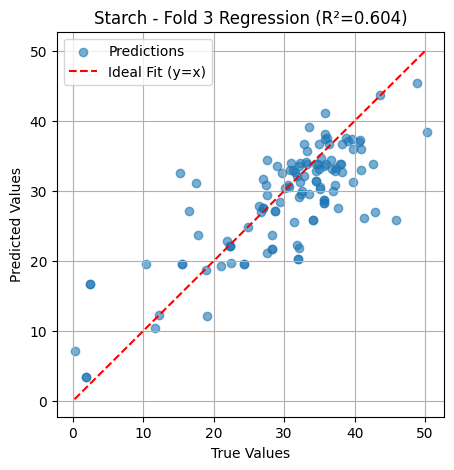


--- Fold 4/5 ---
Epoch 1/200, Loss: 1.2251
Epoch 2/200, Loss: 1.0873
Epoch 3/200, Loss: 1.0174
Epoch 4/200, Loss: 0.8454
Epoch 5/200, Loss: 1.0631
Epoch 6/200, Loss: 1.0312
Epoch 7/200, Loss: 0.8401
Epoch 8/200, Loss: 0.8968
Epoch 9/200, Loss: 0.9374
Epoch 10/200, Loss: 0.9470
Epoch 11/200, Loss: 0.8857
Epoch 12/200, Loss: 0.7160
Epoch 13/200, Loss: 1.0378
Epoch 14/200, Loss: 0.8215
Epoch 15/200, Loss: 0.8870
Epoch 16/200, Loss: 1.0204
Epoch 17/200, Loss: 0.9902
Epoch 18/200, Loss: 0.9774
Epoch 19/200, Loss: 0.8732
Epoch 20/200, Loss: 0.6866
Epoch 21/200, Loss: 0.9993
Epoch 22/200, Loss: 0.9384
Epoch 23/200, Loss: 0.9639
Epoch 24/200, Loss: 1.0895
Epoch 25/200, Loss: 1.1784
Epoch 26/200, Loss: 0.8441
Epoch 27/200, Loss: 0.8867
Epoch 28/200, Loss: 0.8177
Epoch 29/200, Loss: 0.7360
Epoch 30/200, Loss: 1.0835
Epoch 31/200, Loss: 0.7437
Epoch 32/200, Loss: 1.0323
Epoch 33/200, Loss: 0.8918
Epoch 34/200, Loss: 0.9492
Epoch 35/200, Loss: 0.7077
Epoch 36/200, Loss: 0.7881
Epoch 37/200, Loss:

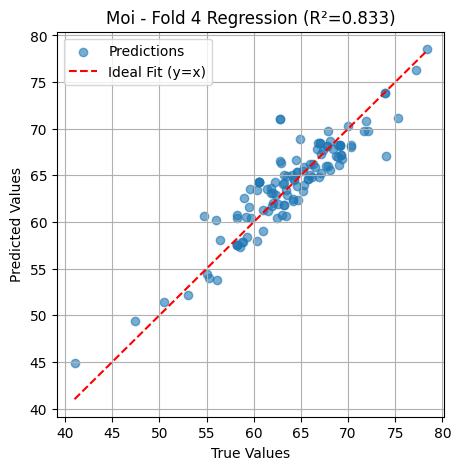

NDF: RMSE=6.085, R2=0.303, RPIQ=1.043


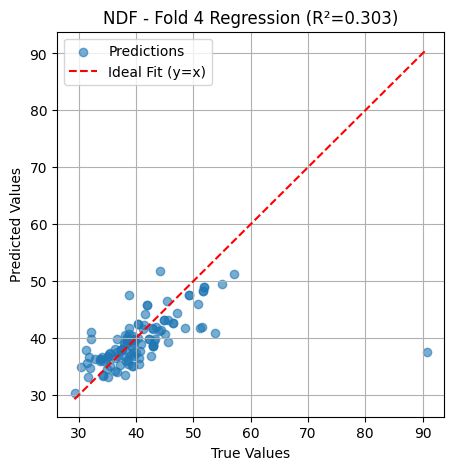

Starch: RMSE=6.437, R2=0.507, RPIQ=1.675


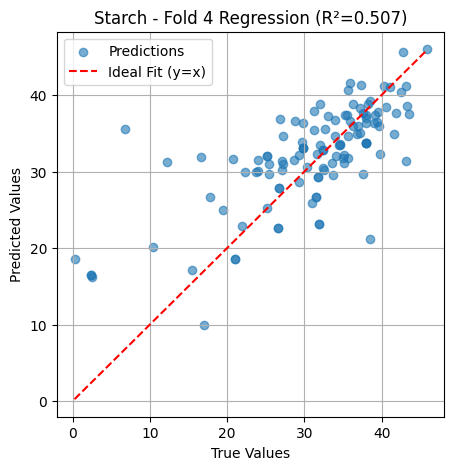


--- Fold 5/5 ---
Epoch 1/200, Loss: 0.7807
Epoch 2/200, Loss: 0.8561
Epoch 3/200, Loss: 0.8649
Epoch 4/200, Loss: 0.9447
Epoch 5/200, Loss: 0.9730
Epoch 6/200, Loss: 1.1305
Epoch 7/200, Loss: 0.9928
Epoch 8/200, Loss: 0.9577
Epoch 9/200, Loss: 0.9640
Epoch 10/200, Loss: 0.9736
Epoch 11/200, Loss: 0.7258
Epoch 12/200, Loss: 1.0037
Epoch 13/200, Loss: 0.9753
Epoch 14/200, Loss: 0.7553
Epoch 15/200, Loss: 0.8631
Epoch 16/200, Loss: 0.7356
Epoch 17/200, Loss: 0.8468
Epoch 18/200, Loss: 0.8968
Epoch 19/200, Loss: 0.8534
Epoch 20/200, Loss: 1.0447
Epoch 21/200, Loss: 0.8090
Epoch 22/200, Loss: 1.1215
Epoch 23/200, Loss: 0.8110
Epoch 24/200, Loss: 0.7664
Epoch 25/200, Loss: 1.0597
Epoch 26/200, Loss: 1.0142
Epoch 27/200, Loss: 1.1606
Epoch 28/200, Loss: 0.8166
Epoch 29/200, Loss: 1.1894
Epoch 30/200, Loss: 0.6950
Epoch 31/200, Loss: 0.8841
Epoch 32/200, Loss: 0.8569
Epoch 33/200, Loss: 0.9674
Epoch 34/200, Loss: 0.8331
Epoch 35/200, Loss: 0.7500
Epoch 36/200, Loss: 0.7525
Epoch 37/200, Loss:

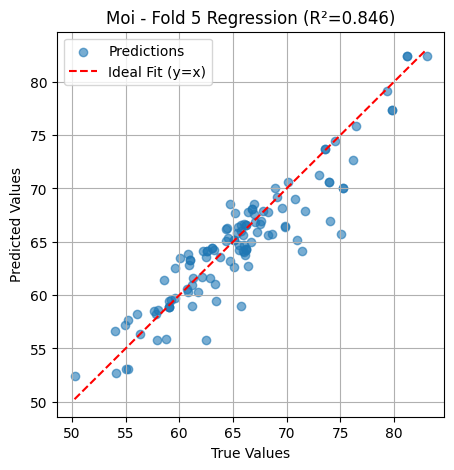

NDF: RMSE=4.235, R2=0.578, RPIQ=1.653


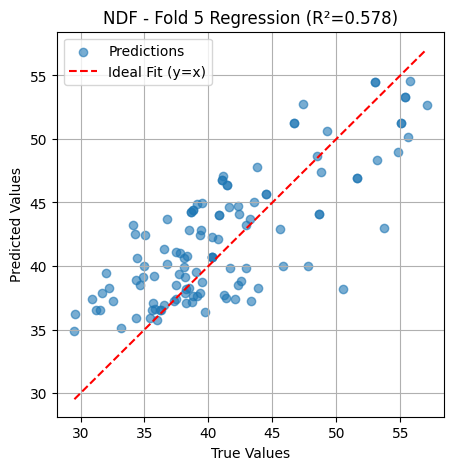

Starch: RMSE=6.934, R2=0.592, RPIQ=1.482


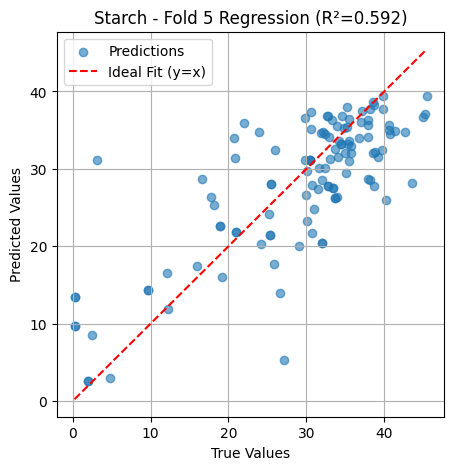

In [18]:
# ====== 5-Fold CV ====== But more Verbose
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
for fold, (t_idx, v_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Verbose mode
        if (epoch+1) % 1 == 0:  # This will print every epoch (verbose=2 equivalent in training)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig); y_pred.append(preds_orig)
    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # Compute and print metrics
    metrics = compute_metrics_orig(y_true, y_pred)
    for i, t in enumerate(TARGETS):
        print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")

        # Plot regression curve for each target
        plt.figure(figsize=(5,5))
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{t} - Fold {fold+1} Regression (R²={metrics[i]['R2']:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()

In [23]:
# ====== Calculate mean of the metrics obtained in each fold in CV ======

# Lists to store metrics for each fold
all_fold_metrics = {target: {"RMSE": [], "R2": [], "RPIQ": []} for target in TARGETS}

# ... (rest of the code from the previous cell for the CV loop)
# After computing metrics for each fold:
for i, t in enumerate(TARGETS):
     print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, RPIQ={metrics[i]['RPIQ']:.3f}")
     all_fold_metrics[t]["RMSE"].append(metrics[i]["RMSE"])
     all_fold_metrics[t]["R2"].append(metrics[i]["R2"])
     all_fold_metrics[t]["RPIQ"].append(metrics[i]["RPIQ"])


Moi: RMSE=2.491, R2=0.846, RPIQ=2.856
NDF: RMSE=4.235, R2=0.578, RPIQ=1.653
Starch: RMSE=6.934, R2=0.592, RPIQ=1.482


Epoch 1/200, Train Loss: 0.9638
Epoch 2/200, Train Loss: 0.9706
Epoch 3/200, Train Loss: 0.9695
Epoch 4/200, Train Loss: 0.9822
Epoch 5/200, Train Loss: 0.9843
Epoch 6/200, Train Loss: 0.9456
Epoch 7/200, Train Loss: 0.9484
Epoch 8/200, Train Loss: 0.9845
Epoch 9/200, Train Loss: 0.9560
Epoch 10/200, Train Loss: 0.9543
Epoch 11/200, Train Loss: 0.9601
Epoch 12/200, Train Loss: 0.9585
Epoch 13/200, Train Loss: 0.9719
Epoch 14/200, Train Loss: 0.9591
Epoch 15/200, Train Loss: 0.9971
Epoch 16/200, Train Loss: 0.9618
Epoch 17/200, Train Loss: 0.9572
Epoch 18/200, Train Loss: 0.9831
Epoch 19/200, Train Loss: 0.9216
Epoch 20/200, Train Loss: 0.9150
Epoch 21/200, Train Loss: 0.9305
Epoch 22/200, Train Loss: 0.9477
Epoch 23/200, Train Loss: 0.9418
Epoch 24/200, Train Loss: 0.9245
Epoch 25/200, Train Loss: 0.9085
Epoch 26/200, Train Loss: 0.9044
Epoch 27/200, Train Loss: 0.9011
Epoch 28/200, Train Loss: 0.8993
Epoch 29/200, Train Loss: 0.8829
Epoch 30/200, Train Loss: 0.8967
Epoch 31/200, Train

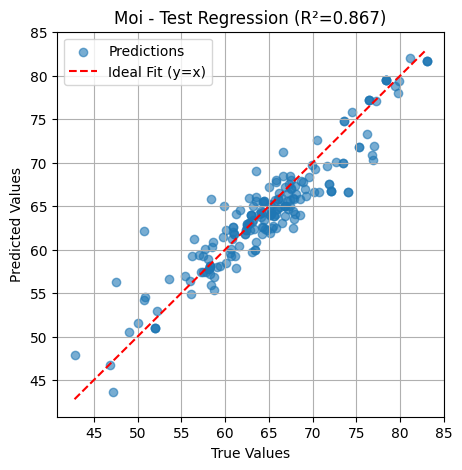

NDF: RMSE=4.129, R2=0.556, RPIQ=1.895


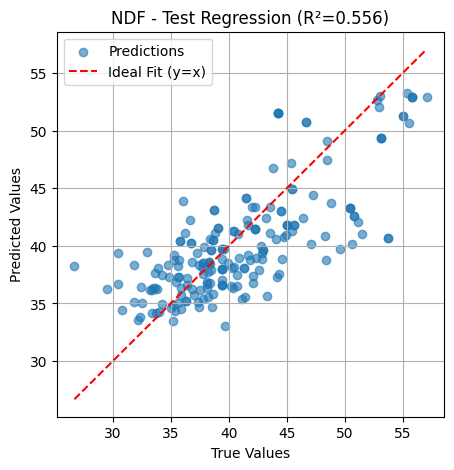

Starch: RMSE=5.794, R2=0.687, RPIQ=1.945


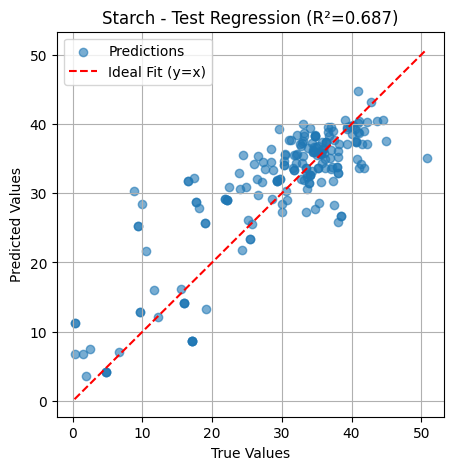

Saved model to /content/SNAKE_images_ready.pth


In [24]:
import matplotlib.pyplot as plt

# ====== Train final on all trainval + test evaluation ======
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(epochs):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss / len(final_loader):.4f}")

# ====== Evaluation ======
final_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = final_model(xb.to(device)).cpu().numpy()
        yb_np = yb.cpu().numpy()
        preds_orig = y_scaler.inverse_transform(preds)
        yb_orig = y_scaler.inverse_transform(yb_np)
        y_true.append(yb_orig)
        y_pred.append(preds_orig)

y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

# ====== Metrics ======
test_metrics = compute_metrics_orig(y_true, y_pred)
print("\n== Test metrics ==")
for i, t in enumerate(TARGETS):
    print(f"{t}: RMSE={test_metrics[i]['RMSE']:.3f}, R2={test_metrics[i]['R2']:.3f}, RPIQ={test_metrics[i]['RPIQ']:.3f}")

    # ====== Plot regression curve ======
    plt.figure(figsize=(5,5))
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
    min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{t} - Test Regression (R²={test_metrics[i]['R2']:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

# ====== Save model ======
file_path = f"/content/{plot_name}_images_ready.pth"
torch.save(final_model.state_dict(), file_path)
print(f"Saved model to {file_path}")


In [25]:
for target in TARGETS:
    min_val = df[target].min()
    max_val = df[target].max()
    print(f"Target: {target}, Min: {min_val:.3f}, Max: {max_val:.3f}")

Target: Moi, Min: 41.001, Max: 83.060
Target: NDF, Min: 26.690, Max: 90.740
Target: Starch, Min: 0.250, Max: 50.800


In [27]:
df2= pd.read_csv("/content/train_df_averaged.csv")
targets = ['Moi','NDF','Starch']
for target in targets:
    min_val = df[target].min()
    max_val = df[target].max()
    print(f"Target: {target}, Min: {min_val:.3f}, Max: {max_val:.3f}")

Target: Moi, Min: 41.001, Max: 83.060
Target: NDF, Min: 26.690, Max: 90.740
Target: Starch, Min: 0.250, Max: 50.800
